# Trabalho A2 - Banco de Dados
## Tema : UFC Lutas
#### Link  Base de Dados : https://www.kaggle.com/mdabbert/ultimate-ufc-dataset?select=ufc-master.csv

### Alunos: Germano Andrade e João Alcindo

In [1]:
import os
import operator
import codecs
import random
import math
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
import networkx as nx

from collections import Counter, OrderedDict

import urllib
from bs4 import BeautifulSoup
#import pydot

#import datashader as ds
#import datashader.transfer_functions as tf
#from datashader.layout import random_layout, circular_layout, forceatlas2_layout
#from datashader.bundling import connect_edges, hammer_bundle

#import holoviews.operation.datashader as hd
#import holoviews as hv
#hv.extension("bokeh")

from SPARQLWrapper import SPARQLWrapper, JSON    #sudo pip3 install --upgrade SPARQLWrapper

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

In [2]:
#Lendo o csv:
df = pd.read_csv("./Databases/ufc-master.csv")

#Filtrando os dados desejados:
df = df[["R_fighter","B_fighter","date","location","country","Winner","title_bout","weight_class","gender","R_age","B_age"]] 

In [3]:
# Imprimindo os 10 primeiros dados:
df.head(10)

,R_fighter,B_fighter,date,location,country,Winner,title_bout,weight_class,gender,R_age,B_age
0,Thiago Santos,Glover Teixeira,11/7/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Light Heavyweight,MALE,36,41
1,Andrei Arlovski,Tanner Boser,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Heavyweight,MALE,41,29
2,Raoni Barcelos,Khalid Taha,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Bantamweight,MALE,33,28
3,Claudia Gadelha,Yan Xiaonan,11/7/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Women's Strawweight,FEMALE,31,31
4,Trevin Giles,Bevon Lewis,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Middleweight,MALE,28,29
5,Giga Chikadze,Jamey Simmons,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,32,28
6,Alexandr Romanov,Marcos Rogerio de Lima,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Heavyweight,MALE,29,35
7,Darren Elkins,Eduardo Garagorri,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,36,31
8,Max Griffin,Ramiz Brahimaj,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Welterweight,MALE,34,27
9,Gustavo Lopez,Anthony Birchak,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Bantamweight,MALE,31,34


In [4]:
#Criando novas colunas no dataframe:
df['Winner_w'] = np.NaN
df['Loser'] = np.NaN
df['W_age'] = np.NaN
df['L_age'] = np.NaN

#Adicionando os vencedores na coluna Winner e os perdedores na coluna Loser,
#o mesmo com as idades nas respectivas colunas(W_age,L_age):
for index, row in df.iterrows():
    if row['Winner'] == "Blue":
        df.loc[index,'Winner_w'] =  df.loc[index,'B_fighter']
        df.loc[index,'Loser'] =  df.loc[index,'R_fighter']
        df.loc[index,'W_age'] =  df.loc[index,'B_age']
        df.loc[index,'L_age'] =  df.loc[index,'R_age']
    elif row['Winner'] == "Red":
        df.loc[index,'Winner_w'] =  df.loc[index,'R_fighter']
        df.loc[index,'Loser'] =  df.loc[index,'B_fighter']
        df.loc[index,'W_age'] =  df.loc[index,'R_age']
        df.loc[index,'L_age'] =  df.loc[index,'B_age']

In [5]:
#Filtrando novamente os dados, agora retirando as colunas R_fighter,B_fighter, Winner, R_age e B_age:
df = df[["Winner_w","Loser","date","location","country","title_bout","weight_class","gender","W_age","L_age"]] 

#Renomeando a coluna Winner_w, chamando a de Winner:
df.rename(columns={'Winner_w':'Winner'}, inplace=True)

In [6]:
# Imprimindo os 10 primeiros dados:
df.head(10)

,Winner,Loser,date,location,country,title_bout,weight_class,gender,W_age,L_age
0,Glover Teixeira,Thiago Santos,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Light Heavyweight,MALE,41.0,36.0
1,Andrei Arlovski,Tanner Boser,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Heavyweight,MALE,41.0,29.0
2,Raoni Barcelos,Khalid Taha,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Bantamweight,MALE,33.0,28.0
3,Yan Xiaonan,Claudia Gadelha,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Women's Strawweight,FEMALE,31.0,31.0
4,Trevin Giles,Bevon Lewis,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Middleweight,MALE,28.0,29.0
5,Giga Chikadze,Jamey Simmons,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Featherweight,MALE,32.0,28.0
6,Alexandr Romanov,Marcos Rogerio de Lima,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Heavyweight,MALE,29.0,35.0
7,Darren Elkins,Eduardo Garagorri,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Featherweight,MALE,36.0,31.0
8,Max Griffin,Ramiz Brahimaj,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Welterweight,MALE,34.0,27.0
9,Gustavo Lopez,Anthony Birchak,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Bantamweight,MALE,31.0,34.0


### Descrição do Dataframe:

|Coluna|Tipo|Descrição|  
|:-|:-|:-|
|**Winner**|varchar(45)| Vencedor da luta|  
|**Loser**|varchar(45)| Perdedor da luta|   
|**date**|datetime| Dia da luta|   
|**location**|varchar(45)| Cidade, Estado e país onde ocorreu a luta|   
|**country**|varchar(30)|  País em que a luta ocorreu|  
|**title_bout**|boolean| Indica se a luta valia disputa de cinturão ou não|   
|**weight_class**|varchar(25)|  Categoria de peso|  
|**gender**|varchar(10)|  Gênero dos lutadores|  
|**W_age**|decimal(3,1)|  Idade do vencedor|  
|**L_age**|decimal(3,1)|  Idade do perdedor|  

In [7]:
df = df[df['weight_class']=="Light Heavyweight"]
G = nx.DiGraph()
#add nodes
for idx in df.index:
    if df.loc[idx,'Winner'] not in G:
        G.add_node(df.loc[idx,'Winner'],frequency=1)
    else:
        G.nodes[df.loc[idx,'Winner']]['frequency'] +=1
    
    if df.loc[idx,'Loser'] not in G:
        G.add_node(df.loc[idx,'Loser'],frequency=1)
        

In [8]:
for idx in df.index:
    if not G.has_edge(df.loc[idx,'Loser'],df.loc[idx,'Winner']):
        G.add_edge(df.loc[idx,'Loser'],df.loc[idx,'Winner'], frequency = 1)
    else:
        G.edges[df.loc[idx,'Loser'],df.loc[idx,'Winner']]['frequency'] += 1

In [9]:
#nx.draw_networkx(G)

print('Number of nodes is: {}'.format(G.number_of_nodes()))
print('Number of edges is: {}'.format(G.number_of_edges()))

Number of nodes is: 175
Number of edges is: 357


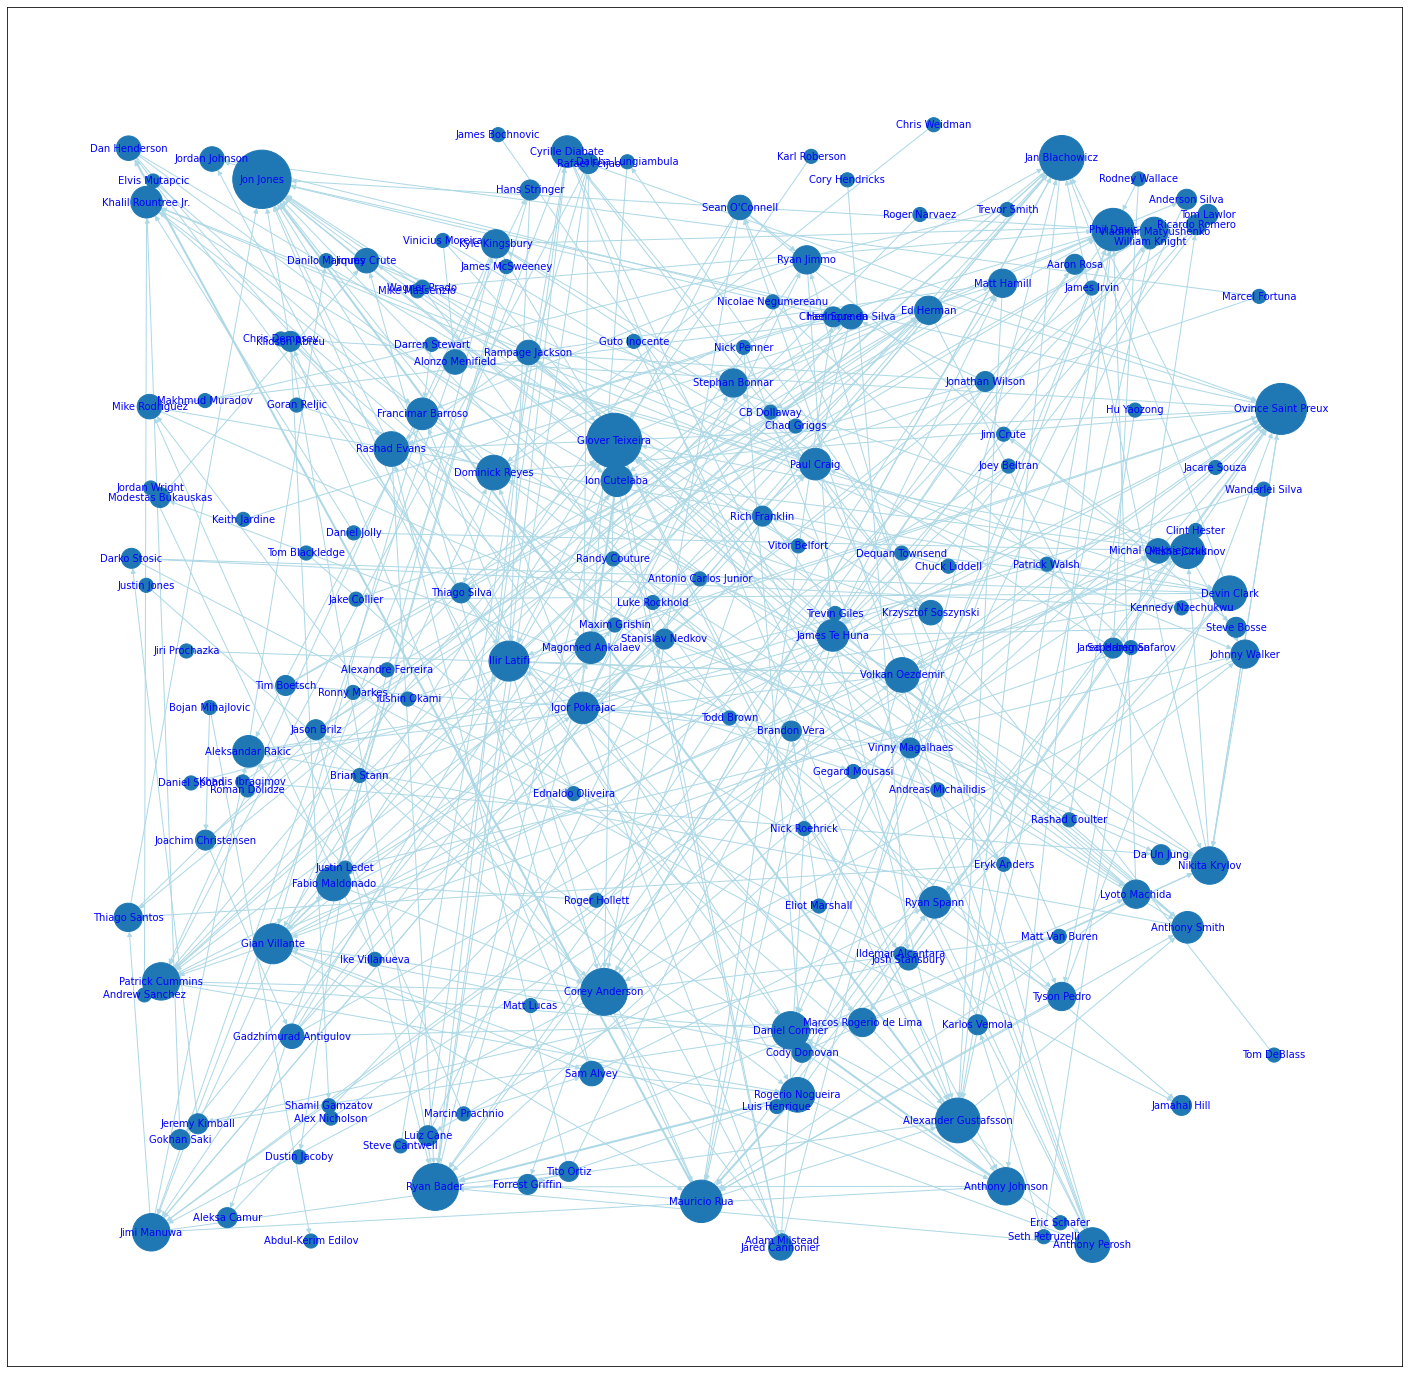

In [28]:
fig, ax = plt.subplots(figsize=(25,25))
pos = nx.random_layout(G, seed=1)

nx.draw_networkx(G,
                node_size=[200*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                width=list(nx.get_edge_attributes(G,'frequency').values()),
                edge_cmap=None,
                edge_vmin=None,
                edge_vmax=None,
                edge_color = "lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='FGraph')